# Importing Libraries

In [16]:
import numpy as np
import cv2
import skimage.transform

from matplotlib import pyplot as plt
from keras.models import load_model

# Loading Sample Image

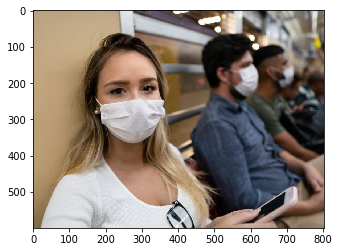

In [17]:
img = cv2.imread('sample.jpg')   # Reads the image in BGR Format
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)  # Converting to RGB format 
plt.imshow(img)                            # Print image in the RGB format

# Loading Caffe Model for Face Detection

In [18]:
prototxtPath = ("deploy.prototxt")
weightsPath = ("res10_300x300_ssd_iter_140000.caffemodel")

net = cv2.dnn.readNet(prototxtPath,weightsPath) 

# Construting a BLOB and Detecting faces from image

In [19]:
(height, width) = img.shape[:2]

# Making a Blob of Dimension (300x300)
blob = cv2.dnn.blobFromImage(img, 1.0, (300, 300), (104.0, 177.0, 123.0)) 

# Detecting Faces via Caffe Model
net.setInput(blob)
detections = net.forward() 

In [22]:
faces = []
faces_count = 0

for i in range(0, detections.shape[2]):
    confidence = detections[0, 0, i, 2]  
    #In Detections 0,0,i,2 is the confidence while 0,0,i,3:7 are location of the box
    
    # If confidence of the detected object of being a face is above 0.5 then only it is taken into consideration
    if confidence > 0.5:
        
        # Getting the Box location from the Detection
        box = detections[0, 0, i, 3:7] * np.array([width, height, width, height])
        (startX, startY, endX, endY) = box.astype("int")
        
        # If Box exceed the Image Boundaries
        (startX, startY) = (max(0, startX), max(0, startY))
        (endX, endY) = (min(width - 1, endX), min(height - 1, endY))
        
        # Appending all the Coordinates of the Box
        faces_count =+ 1
        faces.append((startX, startY, endX, endY))

In [23]:
print('Number of Faces Detected : ' + str(faces_count))

Number of Faces Detected : 1


# Loading Mask Detector Model and Predicting

In [24]:
mask_detector = load_model('Detector')

# For Storing all the predictions by Mask Detector
prediction = [] 

# For Storing Image after Pre-Processing of all the faces detected
batch = []

for face in faces:
    # (StartX, StartY, EndX, EndY) respectively of the box
    Sx,Sy,Ex,Ey = face
    
    # Croping only the face which will be feeded to the model
    crop_img = img[Sy:Ey, Sx:Ex] 
    
    # Converting Image to Grayscale as Mask-Detection model is trained on it
    gray_img = np.dot(crop_img,[0.2989, 0.5870, 0.1140])   
    
    # Resizing Gray Image ---> (200x200)
    gray_img = skimage.transform.resize(gray_img, (200,200))
    
    # Scaling Gray-Values Between 0 and 1
    gray_img = gray_img/255
    
    # Re-Dimensioning to 4D array that will be feeded to the CNN
    gray_img = np.expand_dims(gray_img, -3)
    gray_img = np.expand_dims(gray_img, -1)
    
    batch.append(gray_img)


for i in range(faces_count):
    
    # Predicting if the person is wearing a mask or not
    pred = mask_detector.predict(batch[i])
    prediction.append(pred)
    print(pred)


[[0.99525166 0.00474833]]


# Drawing Boxes around Detected faces

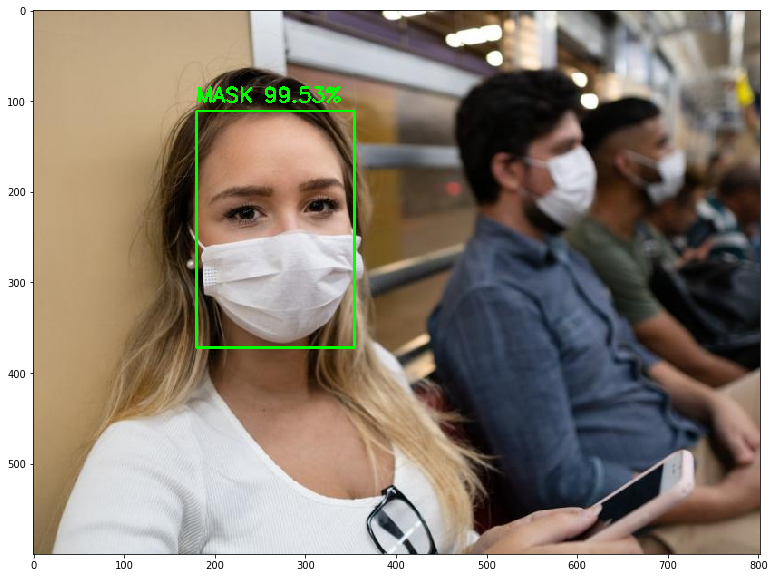

In [25]:
i = 1
n = faces_count
for i in range(faces_count):
    Sx,Sy,Ex,Ey = face
    if prediction[i][0][0] > 0.5 :
        label = 'MASK ' + str(round(prediction[i][0][0]*100,2)) + '%'
        cv2.putText(img, label, (Sx,Sy-10), cv2.FONT_HERSHEY_SIMPLEX, 0.75,(0,255,0), 2)
        cv2.rectangle(img,(Sx,Sy),(Ex,Ey),(0,255,0),2)
    else :
        label = 'NO MASK ' + str(round(prediction[i][0][1]*100,2)) + '%'
        cv2.putText(img, label, (Sx,Sy-10), cv2.FONT_HERSHEY_SIMPLEX, 0.75,(255,0,0), 2)
        cv2.rectangle(img,(Sx,Sy),(Ex,Ey),(255,0),2)
        
plt.show()
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
ax.imshow(img)